In [4]:
import numpy as np
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator

## Exponentials of Pauli strings

First, let's check that the circuit $CX (I \otimes R_z) CX$ actually implements $R_zz(\theta) = \exp(-i \frac{\theta}{2} ZZ)$.

In [5]:
ident = np.array([[1, 0], [0, 1]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_x = np.array([[0, 1], [1, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

def pauli_product(pauli_string):
    """Helper method to compute kronecker product of Paulis"""

    prod = 1
    for p in pauli_string:
        print(p, end="")
        if p == "I":
            prod = np.kron(prod, ident)
        if p == "X":
            prod = np.kron(prod, pauli_x)
        elif p == "Y":
            prod = np.kron(prod, pauli_y)
        elif p == "Z":
            prod = np.kron(prod, pauli_z)
    print("\n")

    return prod


In [6]:
print(pauli_product("ZX"))

ZX

[[ 0  1  0  0]
 [ 1  0  0  0]
 [ 0  0  0 -1]
 [ 0  0 -1  0]]


In [7]:
param = np.pi

zz = QuantumCircuit(2)
zz.rzz(param, 0, 1)
zz.draw()

q_0: ─■──────
      │ZZ(π) 
q_1: ─■──────

In [8]:
zz.decompose().draw()

q_0: ──■─────────────■──
     ┌─┴─┐┌───────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(π) ├┤ X ├
     └───┘└───────┘└───┘

In [9]:
zz_mat = expm(-1j * 0.5 * param * pauli_product("ZZ"))
zz_gate_mat = Operator(zz).data
print(np.allclose(zz_mat, zz_gate_mat))


ZZ

True


Now, lets do a more complicated example

In [10]:
pauli_string = "XYZX"

In [11]:
qc_pauli = QuantumCircuit(4)
qc_pauli.h(0)
# qc_pauli.rx(np.pi/2, 2)
qc_pauli.sdg(2)
qc_pauli.h(2)
qc_pauli.h(3)
qc_pauli.barrier()
qc_pauli.cx([0, 1, 2], [1, 2, 3])
qc_pauli.rz(2, 3)
qc_pauli.cx([2, 1, 0], [3, 2, 1])
qc_pauli.barrier()
qc_pauli.h(0)
# qc_pauli.rx(-np.pi/2, 2)
qc_pauli.h(2)
qc_pauli.s(2)
qc_pauli.h(3)

qc_pauli.draw()

┌───┐       ░                                         ░ ┌───┐     
q_0: ─┤ H ├───────░───■─────────────────────────────────■───░─┤ H ├─────
      └───┘       ░ ┌─┴─┐                             ┌─┴─┐ ░ └───┘     
q_1: ─────────────░─┤ X ├──■───────────────────────■──┤ X ├─░───────────
     ┌─────┐┌───┐ ░ └───┘┌─┴─┐                   ┌─┴─┐└───┘ ░ ┌───┐┌───┐
q_2: ┤ Sdg ├┤ H ├─░──────┤ X ├──■─────────────■──┤ X ├──────░─┤ H ├┤ S ├
     └┬───┬┘└───┘ ░      └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘      ░ ├───┤└───┘
q_3: ─┤ H ├───────░───────────┤ X ├┤ Rz(2) ├┤ X ├───────────░─┤ H ├─────
      └───┘       ░           └───┘└───────┘└───┘           ░ └───┘

In [12]:
pauli_prod = pauli_product(pauli_string)
pauli_mat = expm(-1j * pauli_prod)

XYZX



In [13]:
np.allclose(pauli_mat, Operator(qc_pauli).data)

True

##### The `PauliEvolutionGate`

In [19]:
pauli_gate = PauliEvolutionGate(SparsePauliOp([pauli_string]))

In [12]:
qc_pauli_gate = QuantumCircuit(len(pauli_string))
qc_pauli_gate.append(pauli_gate, qc_pauli_gate.qubits)
qc_pauli_gate.decompose().draw()

┌───┐                ┌───┐┌───────┐┌───┐┌───┐               
q_0: ─┤ H ├────────────────┤ X ├┤ Rz(2) ├┤ X ├┤ H ├───────────────
      └───┘           ┌───┐└─┬─┘└───────┘└─┬─┘├───┤               
q_1: ─────────────────┤ X ├──■─────────────■──┤ X ├───────────────
     ┌─────┐┌───┐┌───┐└─┬─┘                   └─┬─┘┌───┐┌───┐┌───┐
q_2: ┤ Sdg ├┤ H ├┤ X ├──■───────────────────────■──┤ X ├┤ H ├┤ S ├
     └┬───┬┘└───┘└─┬─┘                             └─┬─┘├───┤└───┘
q_3: ─┤ H ├────────■─────────────────────────────────■──┤ H ├─────
      └───┘                                             └───┘

In [13]:
np.allclose(pauli_mat, Operator(qc_pauli_gate).data)

True

## Trotter evolution of a transverse field Ising model

We want to implement the time evolution of the transverse field Ising Hamiltonian with
- 4 sites on a chain
- periodic boundary conditions
- nearest neighbor interactions

$$
H = J \sum_{i} Z_i Z_{i+1} + h \sum_i X_i
$$

In [14]:
# define basic parameters
N = 4
J = 1
h = 0.6
pbc = True

In [15]:
def get_H_op(N, J, h, pbc):
    """Define the two non-commuting parts of the Hamiltonian separately."""
    
    z_op_strings = []
    for i in range(N - 1):
        z_op_strings.append((N - 2 - i)*"I" + "Z" + "Z" + i*"I")
    # last term for periodic BC
    if pbc:
        z_op_strings.append("Z" + (N - 2)*"I" + "Z")
    
    x_op_strings = []
    for i in range(N):
        x_op_strings.append(((N - 1 - i)*"I" + "X" + i*"I"))

    z_ops = SparsePauliOp(data=z_op_strings, coeffs = [J] * (N if pbc else N - 1))
    x_ops = SparsePauliOp(data=x_op_strings, coeffs = [h] * N)
    
    return z_ops, x_ops

In [16]:
z_ops, x_ops = get_H_op(N, J, h, pbc)
H_op = z_ops + x_ops
mag_ave = SparsePauliOp(data=[((N - 1 - i)*"I" + "Z" + i*"I")
                        for i in range(N)], coeffs=[1 / N] * N)
                        
print(f"H_Z =\n{z_ops}")
print(f"H_X =\n{x_ops}")
print(f"H_ising =\n{H_op}")
print(f"M_average =\n{mag_ave}")

mag_ave = mag_ave.to_matrix()

H_Z =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
H_X =
SparsePauliOp(['IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[0.6+0.j, 0.6+0.j, 0.6+0.j, 0.6+0.j])
H_ising =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.6+0.j, 0.6+0.j, 0.6+0.j, 0.6+0.j])
M_average =
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


## Exact evolution

We define two methods
- one to get the initial state, which will simply be the $|0 \rangle$ state
- one to implement the exact evolution for reference

In [17]:
def init_state(N):
    psi_init = np.zeros(1<<N)
    psi_init[0] = 1
    return psi_init

def exact_evo(N, H, t_eval, obs):
    # get initial state
    psi_init = init_state(N)
    # intitialize array to store expectation values at every time step
    expect_vals = []
    init_state_revival = []
    # loop through time values up to final time
    for t in t_eval:
        # evolve statevector for each time step.
        # NOTE: this is exact since we have access to the exponential of the FULL Hamiltonain matrix
        # and do not need to decompose into exponentials of individual summands
        psi = expm_multiply(-1j * t * H, psi_init)
        # compute expectation value at every time step
        # NOTE: we have the full statevector here, so we can evaluate the expectation value exactly
        # by simple matrix-vector-multiplication
        expect_vals.append(np.real(np.conj(psi).dot(obs).dot(psi)))
        overlap = np.conj(psi_init).dot(psi)
        init_state_revival.append(overlap.real**2 + overlap.imag**2)

    return expect_vals, init_state_revival


In [18]:
t_final = 10 * np.abs(J)
dt = 0.1
Nt = int(t_final / dt)
t_eval = np.linspace(0, t_final, Nt + 1)

In [19]:
exact_res, init_state_revival = exact_evo(N, H_op.to_matrix(sparse=True), t_eval, mag_ave)

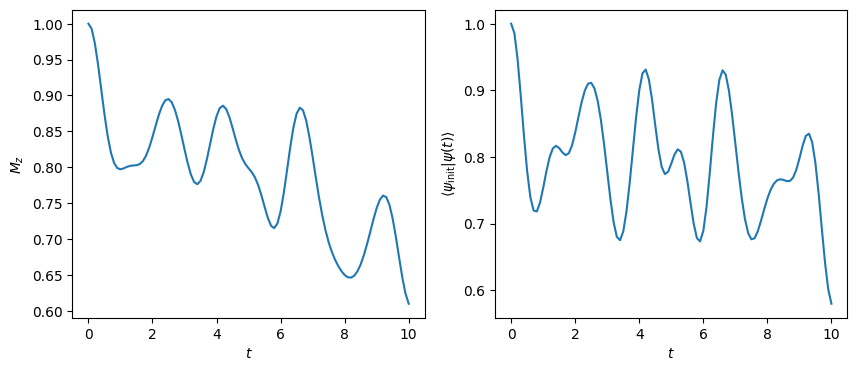

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axs[0].plot(t_eval, exact_res)
axs[0].set_xlabel(rf"$t$")
axs[0].set_ylabel(rf"$M_z$")

axs[1].plot(t_eval, init_state_revival)
axs[1].set_xlabel(rf"$t$")
axs[1].set_ylabel(rf"$\langle \psi_{{\rm init}} | \psi(t) \rangle$")

plt.show()

## Trotter circuit

Let's do the same but with a quantum circuit.

In [21]:
from qiskit import QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate

def ising_trotter_circ(H_list, N, t_final, dt, init_circ=None):
    """This method implements a Trotter circuit for the time evolution of the transverse field Ising model."""
    Nt = int(np.round(t_final / dt))

    # ZZ terms of the Hamiltonian
    z_ops = H_list[0]
    z_circ = QuantumCircuit(N)
    for i, coeff in enumerate(z_ops.coeffs):
        # indices of qubits acted on by Rzz gate, keeping in mind periodic boundaty conditions
        if not i == N - 1:
            n, m = i, i + 1
        else:
            n, m = N - 1, 0

        # R_zz(t) implements exp(-i t ZZ / 2 ), so need to account for the factor of 2
        z_circ.rzz(2 * float(coeff) * dt, n, m)

    # X terms of the Hamiltonian
    x_ops = H_list[1]
    x_circ = QuantumCircuit(N)
    for i, coeff in enumerate(x_ops.coeffs):
        # need to account for the factor of 2 again
        x_circ.rx(2 * float(coeff) * dt, i)

    qreg = QuantumRegister(N)
    evo_circ = QuantumCircuit(qreg)
    if init_circ is not None:
        evo_circ.append(init_circ, qreg)
    for _ in range(Nt):
        evo_circ.append(x_circ, qreg)
        evo_circ.append(z_circ, qreg)
        evo_circ.barrier()

    return evo_circ

def ising_trotter_circ_short(H_list, N, t_final, dt, init_circ=None):
    """This method implements a Trotter circuit for the time evolution of the transverse field Ising model."""
    Nt = int(np.round(t_final / dt))

    # ZZ-gate
    z_ops = H_list[0]
    z_circ = PauliEvolutionGate(z_ops, dt)

    x_ops = H_list[1]
    x_circ = PauliEvolutionGate(x_ops, dt)

    qreg = QuantumRegister(N)
    evo_circ = QuantumCircuit(qreg)
    if init_circ is not None:
        evo_circ.append(init_circ, qreg)
    for _ in range(Nt):
        evo_circ.append(x_circ, qreg)
        evo_circ.append(z_circ, qreg)
        evo_circ.barrier()

    return evo_circ



In [22]:
circ = ising_trotter_circ([z_ops, x_ops], N, 2, 0.5)
circ.decompose().draw()

/tmp/ipykernel_15600/2679585601.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  z_circ.rzz(2 * float(coeff) * dt, n, m)
/tmp/ipykernel_15600/2679585601.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  x_circ.rx(2 * float(coeff) * dt, i)


┌─────────┐                                 ░ ┌─────────┐                »
q0_0: ┤ Rx(0.6) ├─■───────────────────────■───────░─┤ Rx(0.6) ├─■──────────────»
      ├─────────┤ │ZZ(1)                  │       ░ ├─────────┤ │ZZ(1)         »
q0_1: ┤ Rx(0.6) ├─■───────■───────────────┼───────░─┤ Rx(0.6) ├─■───────■──────»
      ├─────────┤         │ZZ(1)          │       ░ ├─────────┤         │ZZ(1) »
q0_2: ┤ Rx(0.6) ├─────────■───────■───────┼───────░─┤ Rx(0.6) ├─────────■──────»
      ├─────────┤                 │ZZ(1)  │ZZ(1)  ░ ├─────────┤                »
q0_3: ┤ Rx(0.6) ├─────────────────■───────■───────░─┤ Rx(0.6) ├────────────────»
      └─────────┘                                 ░ └─────────┘                »
«                       ░ ┌─────────┐                                 ░ »
«q0_0: ─────────■───────░─┤ Rx(0.6) ├─■───────────────────────■───────░─»
«               │       ░ ├─────────┤ │ZZ(1)                  │       ░ »
«q0_1: ─────────┼───────░─┤ Rx(0.6) ├─■───────■───────────────┼───────░─»
«               │       ░ ├─────────┤         │ZZ(1)          │       ░ »
«q0_2: ─■───────┼───────░─┤ Rx(0.6) ├─────────■───────■───────┼───────░─»
«       │ZZ(1)  │ZZ(1)  ░ ├─────────┤                 │ZZ(1)  │ZZ(1)  ░ »
«q0_3: ─■───────■───────░─┤ Rx(0.6) ├─────────────────■───────■───────░─»
«                       ░ └─────────┘                                 ░ »
«      ┌─────────┐                                 ░ 
«q0_0: ┤ Rx(0.6) ├─■───────────────────────■───────░─
«      ├─────────┤ │ZZ(1)                  │       ░ 
«q0_1: ┤ Rx(0.6) ├─■───────■───────────────┼───────░─
«      ├─────────┤         │ZZ(1)          │       ░ 
«q0_2: ┤ Rx(0.6) ├─────────■───────■───────┼───────░─
«      ├─────────┤                 │ZZ(1)  │ZZ(1)  ░ 
«q0_3: ┤ Rx(0.6) ├─────────────────■───────■───────░─
«      └─────────┘                                 ░

In [23]:
circ = ising_trotter_circ_short([z_ops, x_ops], N, 2, 0.5)
circ.decompose().decompose().draw()

┌─────────┐                                 ░ ┌─────────┐                »
q1_0: ┤ Rx(0.6) ├─■───────────────────────■───────░─┤ Rx(0.6) ├─■──────────────»
      ├─────────┤ │ZZ(1)                  │       ░ ├─────────┤ │ZZ(1)         »
q1_1: ┤ Rx(0.6) ├─■───────■───────────────┼───────░─┤ Rx(0.6) ├─■───────■──────»
      ├─────────┤         │ZZ(1)          │       ░ ├─────────┤         │ZZ(1) »
q1_2: ┤ Rx(0.6) ├─────────■───────■───────┼───────░─┤ Rx(0.6) ├─────────■──────»
      ├─────────┤                 │ZZ(1)  │ZZ(1)  ░ ├─────────┤                »
q1_3: ┤ Rx(0.6) ├─────────────────■───────■───────░─┤ Rx(0.6) ├────────────────»
      └─────────┘                                 ░ └─────────┘                »
«                       ░ ┌─────────┐                                 ░ »
«q1_0: ─────────■───────░─┤ Rx(0.6) ├─■───────────────────────■───────░─»
«               │       ░ ├─────────┤ │ZZ(1)                  │       ░ »
«q1_1: ─────────┼───────░─┤ Rx(0.6) ├─■───────■───────────────┼───────░─»
«               │       ░ ├─────────┤         │ZZ(1)          │       ░ »
«q1_2: ─■───────┼───────░─┤ Rx(0.6) ├─────────■───────■───────┼───────░─»
«       │ZZ(1)  │ZZ(1)  ░ ├─────────┤                 │ZZ(1)  │ZZ(1)  ░ »
«q1_3: ─■───────■───────░─┤ Rx(0.6) ├─────────────────■───────■───────░─»
«                       ░ └─────────┘                                 ░ »
«      ┌─────────┐                                 ░ 
«q1_0: ┤ Rx(0.6) ├─■───────────────────────■───────░─
«      ├─────────┤ │ZZ(1)                  │       ░ 
«q1_1: ┤ Rx(0.6) ├─■───────■───────────────┼───────░─
«      ├─────────┤         │ZZ(1)          │       ░ 
«q1_2: ┤ Rx(0.6) ├─────────■───────■───────┼───────░─
«      ├─────────┤                 │ZZ(1)  │ZZ(1)  ░ 
«q1_3: ┤ Rx(0.6) ├─────────────────■───────■───────░─
«      └─────────┘                                 ░

In [24]:
t_final = 10
dt_trotter = 0.2
Nt_trotter = int(t_final / dt_trotter)
t_eval_trotter = np.linspace(0, t_final, Nt_trotter + 1)

init_circ = QuantumCircuit(N)

trotter_circ_res = []
for t in t_eval_trotter:
    circ = ising_trotter_circ([z_ops, x_ops], N, t, dt_trotter, init_circ)
    psi = Statevector(circ).data
    trotter_circ_res.append(np.abs(np.conj(psi).dot(mag_ave).dot(psi)))


/tmp/ipykernel_15600/2679585601.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  z_circ.rzz(2 * float(coeff) * dt, n, m)
/tmp/ipykernel_15600/2679585601.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  x_circ.rx(2 * float(coeff) * dt, i)


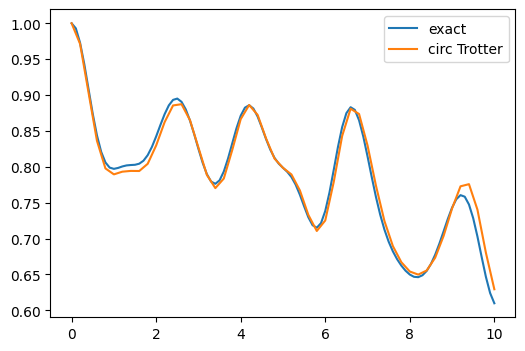

In [25]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot(t_eval, exact_res, label="exact")
ax.plot(t_eval_trotter, trotter_circ_res, label="circ Trotter")

ax.legend()
plt.show()
